In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import math
import datetime
# import main_func
import facebook_datacollector_test as collector
import pandas as pd
import mysql_adactivity_save as mysql_saver
import adgeek_permission as permission
# sizepop, vardim, MAXGEN, params = 2000, 3, 30, [0.9, 0.5, 0.5]
sizepop, vardim, MAXGEN, params = 1000, 7, 15, [0.9, 0.5, 0.5]
BRANDING_CAMPAIGN_LIST = [
    'THRUPLAY', 'LINK_CLICKS', 'ALL_CLICKS','VIDEO_VIEWS', 'REACH', 'IMPRESSIONS', 'POST_ENGAGEMENT', 'PAGE_LIKES', 'LANDING_PAGE_VIEW']
PERFORMANCE_CAMPAIGN_LIST = [
    'CONVERSIONS', 'LEAD_GENERATION', 'ADD_TO_CART']

In [2]:
class GeneticAlgorithm(object):
    '''
    The class for genetic algorithm
    '''
    def __init__(self, sizepop, vardim, bound, MAXGEN, params):
        '''
        sizepop: population sizepop 種群數量
        vardim: dimension of variables 變量維度
        bound: boundaries of variables 變量邊界 -10 10 (最佳化權重上下限)
        MAXGEN: termination condition  迭代次數  1000 (子代代數)
        param: 交叉率, 變異率, alpha = [0.9, 0.1, 0.5]
        '''
        self.sizepop = sizepop
        self.MAXGEN = MAXGEN
        self.vardim = vardim
        self.bound = bound
        self.population = []
        self.fitness = np.zeros((self.sizepop, 1))
        self.trace = np.zeros((self.MAXGEN, 2))
        self.params = params

    def initialize(self):
        '''
        initialize the population
        '''
        for i in range(0, self.sizepop):
            ind = GAIndividual(self.vardim, self.bound)
            ind.generate()
            self.population.append(ind)

    def evaluate(self):
        '''
        evaluation of the population fitnesses
        '''
        for i in range(0, self.sizepop):
            self.population[i].calculateFitness()
            self.fitness[i] = self.population[i].fitness

    def solve(self):
        '''
        evolution process of genetic algorithm
        '''
        self.t = 0
        self.initialize()
        self.evaluate()
        best = np.max(self.fitness)
        bestIndex = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[bestIndex])
        self.avefitness = np.mean(self.fitness)
        self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
        self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
        print("Generation %d: optimal function value is: %f; average function value is %f" % (
            self.t, self.trace[self.t, 0], self.trace[self.t, 1]))
        while (self.t < self.MAXGEN - 1):
            self.t += 1
            self.selectionOperation()
            self.crossoverOperation()
            self.mutationOperation()
            self.evaluate()
            best = np.max(self.fitness)
            bestIndex = np.argmax(self.fitness)
            if best > self.best.fitness:
                self.best = copy.deepcopy(self.population[bestIndex])
            self.avefitness = np.mean(self.fitness)
#             self.trace[self.t, 0] = (1 - self.best.fitness) / self.best.fitness
#             self.trace[self.t, 1] = (1 - self.avefitness) / self.avefitness
            self.trace[self.t, 0] = self.best.fitness
            self.trace[self.t, 1] = self.avefitness
            print("Generation %d: optimal function value is: %f; average function value is %f" % (
                self.t, self.trace[self.t, 0], self.trace[self.t, 1]))

        print("Optimal function value is: %f; " %
              self.trace[self.t, 0])
        print ("Optimal solution is:")
        print(self.best.chrom)
        self.printResult()
        return self.best.chrom
    
    def selectionOperation(self):
        '''
        selection operation for Genetic Algorithm
        '''
        newpop = []
        totalFitness = np.sum(self.fitness)
        accuFitness = np.zeros((self.sizepop, 1))

        sum1 = 0.
        for i in range(0, self.sizepop):
            accuFitness[i] = sum1 + self.fitness[i] / totalFitness
            sum1 = accuFitness[i]

        for i in range(0, self.sizepop):
            r = random.random()
            idx = 0
            for j in range(0, self.sizepop - 1):
                if j == 0 and r < accuFitness[j]:
                    idx = 0
                    break
                elif r >= accuFitness[j] and r < accuFitness[j + 1]:
                    idx = j + 1
                    break
            newpop.append(self.population[idx])
        self.population = newpop

    def crossoverOperation(self):
        '''
        crossover operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop, 2):
            idx1 = random.randint(0, self.sizepop - 1)
            idx2 = random.randint(0, self.sizepop - 1)
            while idx2 == idx1:
                idx2 = random.randint(0, self.sizepop - 1)
            newpop.append(copy.deepcopy(self.population[idx1]))
            newpop.append(copy.deepcopy(self.population[idx2]))
            r = random.random()
            if r < self.params[0]:
                crossPos = random.randint(1, self.vardim - 1)
                for j in range(crossPos, self.vardim):
                    newpop[i].chrom[j] = newpop[i].chrom[
                        j] * self.params[2] + (1 - self.params[2]) * newpop[i + 1].chrom[j]
                    newpop[i + 1].chrom[j] = newpop[i + 1].chrom[j] * self.params[2] + \
                        (1 - self.params[2]) * newpop[i].chrom[j]
        self.population = newpop

    def mutationOperation(self):
        '''
        mutation operation for genetic algorithm
        '''
        newpop = []
        for i in range(0, self.sizepop):
            newpop.append(copy.deepcopy(self.population[i]))
            r = random.random()
            if r < self.params[1]:
                mutatePos = random.randint(0, self.vardim - 1)
                theta = random.random()
                if theta > 0.5:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] - (newpop[i].chrom[mutatePos] - self.bound[0, mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
                else:
                    newpop[i].chrom[mutatePos] = newpop[i].chrom[
                        mutatePos] + (self.bound[1, mutatePos] - newpop[i].chrom[mutatePos]) * (1 - random.random() ** (1 - self.t / self.MAXGEN))
        self.population = newpop

    def printResult(self):
        '''
        plot the result of the genetic algorithm
        '''
        x = np.arange(0, self.MAXGEN)
        y1 = self.trace[:, 0]
        y2 = self.trace[:, 1]
        plt.plot(x, y1, 'r', label='optimal value')
        plt.plot(x, y2, 'g', label='average value')
        plt.xlabel("Iteration")
        plt.ylabel("function value")
        plt.title("Genetic algorithm for function optimization")
        plt.legend()
        plt.show()

class GAIndividual(object):
    '''
    individual of genetic algorithm
    '''
    def __init__(self,  vardim, bound):
        '''
        vardim: dimension of variables
        bound: boundaries of variables
        '''
        self.vardim = vardim
        self.bound = bound
        self.fitness = 0.

    def generate(self):
        '''
        generate a random chromsome for genetic algorithm
        '''
        len = self.vardim
        rnd = np.random.random(size=len)
        self.chrom = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i] + \
                (self.bound[1, i] - self.bound[0, i]) * rnd[i]
    def calculateFitness(self):
        '''
        calculate the fitness of the chromsome
        '''
        optimal_weight = OptimalWeight(self.chrom)
        self.fitness = np.dot(optimal_weight.matrix, chromosome.matrix)
#         self.fitness = ObjectiveFunc.fitnessfunc( self.chrom, df )


def ga_optimal_weight(campaign_id):
    request_time = datetime.datetime.now().date()
    mydb = mysql_saver.connectDB( mysql_saver.DATABASE )
    df_weight = pd.read_sql("SELECT * FROM optimal_weight WHERE campaign_id=%s " %(campaign_id), con=mydb)
    df_camp = pd.read_sql("SELECT * FROM campaign_target WHERE campaign_id=%s " %(campaign_id), con=mydb)
    charge_type = df_camp['charge_type'].iloc[0]
    adset_list = collector.Campaigns(campaign_id, charge_type).get_adsets_active()
    if len(df_weight) > 0:
        for adset_id in adset_list:
            df = ObjectiveFunc.adset_status( adset_id, df_camp )
            r = ObjectiveFunc.adset_fitness( df_weight, df )
            print('[score]', r)
            df_final = pd.DataFrame({'campaign_id':campaign_id, 'adset_id':adset_id, 'score':r, 'request_time':request_time}, index=[0])
            try:
                mysql_saver.intoDB("adset_score", df_final)
            except Exception as e:
                print('score is inf: ', e)
                pass
    else:
        pass
    mydb.close()
    return


In [3]:
def generate_optimal_weight_test(campaign_id, charge_type):
    global chromosome
    print('[campaign_id]:', campaign_id )
    print('[current time]: ', datetime.datetime.now() )
    start_time = datetime.datetime.now()
    
    campaign = Campaign(campaign_id)
    chromosome = ObjectChromosome(campaign.condition)
    
    
#     df = ObjectiveFunc.campaign_status(account_id, campaign_id, charge_type)
    
    bound = np.tile([[0], [1]], vardim)
    ga = GeneticAlgorithm(sizepop, vardim, bound, MAXGEN, params)
    result_optimal_weight = ga.solve()
    
    optimal_campaign = CampaignOptimalWeight(campaign_id, charge_type, result_optimal_weight)
    
    score = np.dot(optimal_campaign.matrix, chromosome.matrix)
    print('==========SCORE========')
    print(score)

    score_columns=['w_action', 'w_desire', 'w_interest', 'w_awareness', 'w_discovery', 'w_spend', 'w_bid']
    df_score = pd.DataFrame(data=[optimal_campaign.matrix], columns=score_columns, index=[0])
    df_score['campaign_id'], df_score['score'] = campaign_id, score
# #     print(df_final)
#     mysql_saver.check_optimal_weight(campaign_id, df_final)
    check_optimal_weight(campaign_id, df_score)
    assess_adset(campaign, optimal_campaign)
#     ga_optimal_weight(campaign_id)

    print('[optimal_weight]:', optimal_campaign.matrix)
    print('[operation time]: ', datetime.datetime.now()-start_time)

In [4]:
def assess_adset(campaign_object, campaign_optimal_object):
    for adset in campaign_object.adsets:
        
        chromosome_adset = ObjectChromosome(adset.condition)
        
        score = np.dot(campaign_optimal_object.matrix, chromosome_adset.matrix)
        
        print('=====[adset_id]=====', adset.adset_id, '==========[score]', score)
        df_final = pd.DataFrame({
            'campaign_id':campaign_object.campaign_id, 'adset_id':adset.adset_id, 'score':score}, index=[0])
        mysql_saver.intoDB("adset_score", df_final)


In [5]:
def check_optimal_weight(campaign_id, df):
    from pandas.io import sql
    from sqlalchemy import create_engine
    import pymysql
    pymysql.install_as_MySQLdb()
    import MySQLdb
    import sys
    mydb = mysql_saver.connectDB(mysql_saver.DATABASE)
    df_check = pd.read_sql( "SELECT * FROM campaign_optimal_weight WHERE campaign_id={}".format(campaign_id), con=mydb )
    if df_check.empty:
        engine = create_engine( 'mysql://app:adgeek1234@{}/{}'.format( mysql_saver.HOST, mysql_saver.DATABASE ) )
        with engine.connect() as conn, conn.begin():
            df.to_sql( "campaign_optimal_weight", conn, if_exists='append',index=False )
            engine.dispose()
        return
    else:
        mycursor = mydb.cursor()
        campaign_id = df['campaign_id'].iloc[0]
        df.drop(['campaign_id'], axis=1)
        for column in df.columns:
            try:
                sql = ("UPDATE campaign_optimal_weight SET {}='{}' WHERE campaign_id={}".format( column, df[column].iloc[0], campaign_id))
                mycursor.execute(sql)
                mydb.commit()
            except Exception as e:
                print(e)
                pass
        mycursor.close()
        mydb.close()
        return

In [6]:
def main():
    starttime = datetime.datetime.now()
    print('[start time]: ', starttime)
    
    campaign_list = mysql_saver.get_running_branding_campaign().to_dict('records')
    print([campaign['campaign_id'] for campaign in campaign_list])
    for campaign in campaign_list:
        campaign_id = campaign.get("campaign_id")
        charge_type = campaign.get("charge_type")
        generate_optimal_weight_test(campaign_id, charge_type)
        
    campaign_list = mysql_saver.get_running_performance_campaign().to_dict('records')
    for campaign in campaign_list:
        campaign_id = campaign.get("campaign_id")
        charge_type = campaign.get("charge_type")
        generate_optimal_weight_test(campaign_id, charge_type)
        
    campaign_list = mysql_saver.get_running_custom_conversion_campaign().to_dict('records')
    for campaign in campaign_list:
        campaign_id = campaign.get("campaign_id")
        charge_type = campaign.get("charge_type")
        generate_optimal_weight_test(campaign_id, charge_type)
        
#         generate_optimal_weight(account_id, campaign_id, charge_type)
    print('[total operation time]: ', datetime.datetime.now()-starttime)
    print('genetic algorithm finish.')
    return

In [7]:
class Campaign(object):
    __condition_field = ["action", "desire", "interest", "awareness", "attention", "discovery", "impressions", "destination_daily_spend",
                       "destination_daily_target", "cost_per_action", "spend", "daily_spend", "daily_target", "KPI", "destination_type"]
    def __init__(self, campaign_id):
        self.campaign_id = campaign_id
        self.__get_brief()
        self.brief_dict["destination_type"] = self.brief_dict.pop("charge_type")
        self.destination_type = self.brief_dict.get("destination_type")
        permission.init_facebook_api(self.brief_dict.get("account_id"))
        self.service_collect = collector.Campaigns(self.campaign_id, charge_type=None)
        self.__create_condition()
        self.__get_adsets()
        
    def __get_brief(self):
        mydb = mysql_saver.connectDB( mysql_saver.DATABASE )
        df_list = pd.read_sql(
            "SELECT * FROM campaign_target WHERE campaign_id={}".format(self.campaign_id), con=mydb).to_dict('records')
        mydb.close()
        self.brief_dict = df_list[0]
        self.brief_dict['KPI'] = self.brief_dict.get("ai_spend_cap")/self.brief_dict.get("destination")
    
    def get_weight(self):
        mydb = mysql_saver.connectDB( mysql_saver.DATABASE )
        optimal_weight_list = pd.read_sql(
            "SELECT * FROM campaign_optimal_weight WHERE campaign_id={}".format(self.campaign_id), con=mydb).to_dict('records')
        mydb.close()
        return optimal_weight_list[0]
        
    def __get_adsets(self):
        adset_id_list = self.service_collect.get_adsets_active()
        self.adsets = [ AdSet(self, adset_id) for adset_id in adset_id_list ]
        
    def __create_condition(self):
        self.condition = self.service_collect.generate_info(date_preset = collector.DatePreset.lifetime)
        self.condition.update(self.brief_dict)
        self.condition.update({
            "flight": (datetime.date.today()-self.brief_dict.get("ai_start_date")).days
        })
        self.condition['spend'] = int(self.condition.get("spend") if self.condition.get("spend") else 0)
        self.condition['impressions'] = int(self.condition.get("impressions") if self.condition.get("impressions") else 0)
        self.condition.update({
            "attention": self.condition.get("impressions"),
            "discovery": self.condition.get("reach"),
            "destination_daily_spend": self.condition.get("ai_spend_cap") / self.condition.get("period"),
            "destination_daily_target":self.condition.get("destination") / self.condition.get("period"),
            "cost_per_action": self.condition.get("cost_per_target") if self.condition.get("cost_per_target") else 0,
            "spend": self.condition.get("spend") / self.condition.get("flight") if self.condition.get("flight") != 0 else 1,
            "action": self.condition.get("target") / self.condition.get("flight") if self.condition.get("flight") != 0 else 1,
        })
        self.condition = {k: v for k, v in self.condition.items() if k in self.__condition_field}
        
        
class AdSet(object):
    __condition_field = ["action", "desire", "interest", "awareness", "impressions", "destination_daily_spend",
                         "destination_daily_target", "bid_amount", "cost_per_action", "spend", "KPI", "destination_type"]
    def __init__(self, campaign, adset_id):
        self.campaign = campaign
        self.adset_id = adset_id
        self.destination_type = self.campaign.destination_type
        self.service_collect = collector.AdSets(self.adset_id, charge_type=None)
        self.__create_condition()
        
    def __create_condition(self):
        self.condition = self.service_collect.generate_info(date_preset = collector.DatePreset.lifetime)
        self.condition['spend'] = float(self.condition.get("spend") if self.condition.get("spend") else 0)
        self.condition['impressions'] = int(self.condition.get("impressions") if self.condition.get("impressions") else 0)
        self.condition.update({
            "KPI": self.campaign.condition.get("KPI"),
            "destination_type": self.destination_type,
            "destination_daily_spend": self.campaign.condition.get("destination_daily_spend"),
            "destination_daily_target": self.campaign.condition.get("destination_daily_target"),
            "cost_per_action": int(self.condition.get("spend")) / int(self.condition.get("action")) if int(self.condition.get("action")) != 0 else 0
        })
        self.condition = {k: v for k, v in self.condition.items() if k in self.__condition_field}
        
    def __create_fitness(self):
        self.fitness = Chromosome(self.condition)
        
    def __create_optimal_weight(self):
        self.optimal_weight = OptimalWeight(self.destination_type)






In [8]:
class OptimalWeight(object):        
    def __init__(self, optimal_weight):
        self.matrix = optimal_weight
        self.action = self.matrix[0]
        self.desire = self.matrix[1]
        self.interest = self.matrix[2]
        self.awareness = self.matrix[3]
        self.discovery = self.matrix[4]
        self.spend = self.matrix[5]
        self.kpi = self.matrix[6]

class CampaignOptimalWeight(OptimalWeight):
    def __init__(self, campaign_id, destination_type, optimal_weight):
        super().__init__(optimal_weight)
        self.destination_type = destination_type
        if self.destination_type in collector.BRANDING_CAMPAIGN_LIST:
            self.desire, self.interest, self.awareness, self.discovery = 0, 0, 0, 0
            self.matrix = np.array([
                self.action, self.desire, self.interest, self.awareness, self.discovery, self.spend, self.kpi
            ])

    

In [9]:
class Chromosome(object):
    def __init__(self,):
        self.matrix = np.random.rand(vardim,)
        self.action = self.matrix[0]
        self.desire = self.matrix[1]
        self.interest = self.matrix[2]
        self.awareness = self.matrix[3]
        self.discovery = self.matrix[4]
        self.spend = self.matrix[5]
        self.kpi = self.matrix[6]

class RandomChromosome(Chromosome):
    pass

class ObjectChromosome(Chromosome):
    __fields = [
        "action", "desire", "interest", "awareness", "discovery", "attention", "spend"
    ]
    def __init__(self, condition):
        super().__init__()
        self.condition = condition
        self.destination_type = condition.get("destination_type")
        self.__initialize()
        self.__create_m_action()
        self.__create_m_desire()
        self.__create_m_interest()
        self.__create_m_awareness()
        self.__create_m_discovery()
        self.__create_m_spend()
        self.__create_m_kpi()
        self.__create_matrix()
        
    def __initialize(self):
        for field in self.__fields:
            if not self.condition.get(field):
                self.condition[field] = 0
        
    def __create_m_action(self):
        if self.destination_type in collector.BRANDING_CAMPAIGN_LIST:
            self.m_action = (self.condition.get("destination_daily_target")/int(self.condition.get("action"))) if int(self.condition.get("action")) != 0 else 0
        else:
            self.m_action = (int(self.condition.get("action")) / self.condition.get("desire")) if int(self.condition.get("desire")) != 0 else 0
        
    def __create_m_desire(self):
        if self.destination_type in collector.BRANDING_CAMPAIGN_LIST:
            self.m_desire = 0
        else:
            self.m_desire = (self.condition.get("desire") / self.condition.get("interest")) if self.condition.get("interest") != 0 else 0
        
    def __create_m_interest(self):
        if self.destination_type in collector.BRANDING_CAMPAIGN_LIST:
            self.m_interest = 0
        else:
            self.m_interest = (self.condition.get("interest") / self.condition.get("awareness")) if self.condition.get("awareness") != 0 else 0
        
    def __create_m_awareness(self):
        if self.destination_type in collector.BRANDING_CAMPAIGN_LIST:
            self.m_awareness = 0
        else:
            self.m_awareness = (self.condition.get("awareness") / self.condition.get("discovery")) if self.condition.get("discovery") != 0 else 0
        
    def __create_m_discovery(self):
        if self.destination_type in collector.BRANDING_CAMPAIGN_LIST:
            self.m_discovery = 0
        else:
            self.m_discovery = (self.condition.get("discovery") / self.condition.get("attention")) if self.condition.get("attention") != 0 else 0
        
    def __create_m_spend(self):
        self.m_spend = ( self.condition.get("destination_daily_spend")-self.condition.get("spend")) / self.condition.get("destination_daily_spend")
        
    def __create_m_kpi(self):
        self.m_kpi = ( self.condition.get("KPI")-self.condition.get("cost_per_action") ) / self.condition.get("KPI")
    
    def __create_matrix(self):
        self.matrix = np.array([
            self.m_action, self.m_desire, self.m_interest, self.m_awareness, self.m_discovery, self.m_spend, self.m_kpi
        ])
    
#     pass

[start time]:  2019-08-19 19:28:16.071905
[23843568997400374, 23843447337770036, 23843672578810681, 23843508739720127, 23843628563810022, 23843628364880022]
[campaign_id]: 23843568997400374
[current time]:  2019-08-19 19:28:16.094296
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2019-06-15T00:01:11+0800


[get_adsets_active] adset_active_list: ['23843729917170374', '23843729916640374']


Generation 0: optimal function value is: -0.482703; average function value is 0.362425
Generation 1: optimal function value is: 1.933127; average function value is 1.153461
Generation 2: optimal function value is: 1.933127; average function value is 1.278689
Generation 3: optimal function value is: 1.933351; average function value is 1.377158
Generation 4: optimal function value is: 1.933351; average function value is 1.441936
Generation 5: optimal function value is: 1.933351; average function value is 1.481906
Generation 6: optimal function value is: 1.933351; average function value is 1.521469
Generation 7: optimal function value is: 1.933351; average function value is 1.542916
Generation 8: optimal function value is: 1.934982; average function value is 1.566482
Generation 9: optimal function value is: 1.934982; average function value is 1.588925
Generation 10: optimal function value is: 1.934982; average function value is 1.599001
Generation 11: optimal function value is: 1.934982; 

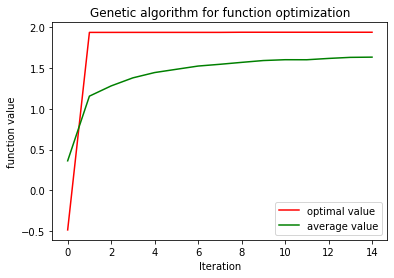

==========SCORE========
1.934982362222749
=====[adset_id]===== 23843729917170374 ==========[score] -1.8179404051787136
=====[adset_id]===== 23843729916640374 ==========[score] 0.8666119877215945
[optimal_weight]: [0.99439673 0.         0.         0.         0.         0.64935597
 0.0477586 ]
[operation time]:  0:00:19.725176
[campaign_id]: 23843447337770036
[current time]:  2019-08-19 19:28:35.820762
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2019-06-19T16:56:48+0800


[get_adsets_active] adset_active_list: ['23843531828830036', '23843516369410036', '23843447338000036', '23843447337980036', '23843447337970036', '23843447337960036']


Generation 0: optimal function value is: 0.013831; average function value is 1.066203
Generation 1: optimal function value is: 0.986358; average function value is 0.633241
Generation 2: optimal function value is: 0.986358; average function value is 0.682822
Generation 3: optimal function value is: 0.986358; average function value is 0.696359
Generation 4: optimal function value is: 0.986358; average function value is 0.710768
Generation 5: optimal function value is: 0.986358; average function value is 0.717399
Generation 6: optimal function value is: 0.986358; average function value is 0.715464
Generation 7: optimal function value is: 0.986358; average function value is 0.716326
Generation 8: optimal function value is: 0.986358; average function value is 0.715696
Generation 9: optimal function value is: 0.986358; average function value is 0.718058
Generation 10: optimal function value is: 0.986358; average function value is 0.720701
Generation 11: optimal function value is: 0.986358; a

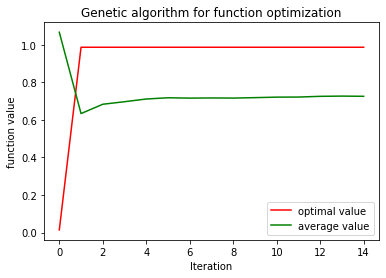

==========SCORE========
0.9863577631476195
=====[adset_id]===== 23843531828830036 ==========[score] 0.9740907042968162
=====[adset_id]===== 23843516369410036 ==========[score] 0.7981666103945387
=====[adset_id]===== 23843447338000036 ==========[score] 0.4108071555912738
=====[adset_id]===== 23843447337980036 ==========[score] 0.8101540300933165
=====[adset_id]===== 23843447337970036 ==========[score] 1.152217404238712
=====[adset_id]===== 23843447337960036 ==========[score] 0.008999120956411977
[optimal_weight]: [0.66603193 0.         0.         0.         0.         0.14367474
 0.99962013]
[operation time]:  0:00:23.157999
[campaign_id]: 23843672578810681
[current time]:  2019-08-19 19:28:58.980195


[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2019-07-16T00:01:21+0800


[get_adsets_active] adset_active_list: ['23843672578870681', '23843672578860681', '23843672578850681', '23843672578840681', '23843672578830681', '23843672578820681', '23843672578800681']


Generation 0: optimal function value is: 0.014538; average function value is 0.992774
Generation 1: optimal function value is: 0.985670; average function value is 0.605442
Generation 2: optimal function value is: 0.985670; average function value is 0.657130
Generation 3: optimal function value is: 0.985670; average function value is 0.690240
Generation 4: optimal function value is: 0.985670; average function value is 0.700614
Generation 5: optimal function value is: 0.985670; average function value is 0.704798
Generation 6: optimal function value is: 0.985670; average function value is 0.711012
Generation 7: optimal function value is: 0.985670; average function value is 0.719831
Generation 8: optimal function value is: 0.985670; average function value is 0.729085
Generation 9: optimal function value is: 0.985670; average function value is 0.727536
Generation 10: optimal function value is: 0.985670; average function value is 0.729801
Generation 11: optimal function value is: 0.985670; a

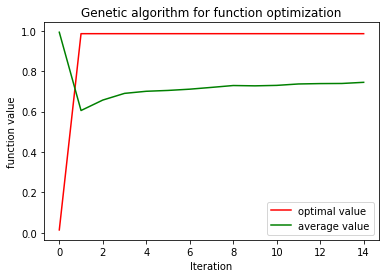

==========SCORE========
0.9856702407769089


=====[adset_id]===== 23843672578870681 ==========[score] 0.8643935502250022
=====[adset_id]===== 23843672578860681 ==========[score] 0.7008198601923812
=====[adset_id]===== 23843672578850681 ==========[score] 0.42550953236621
=====[adset_id]===== 23843672578840681 ==========[score] 133.1455353317944
=====[adset_id]===== 23843672578830681 ==========[score] -1.8758951670627446
=====[adset_id]===== 23843672578820681 ==========[score] 266.43351629597146
=====[adset_id]===== 23843672578800681 ==========[score] 73.4587846794142
[optimal_weight]: [0.99343392 0.         0.         0.         0.         0.10548543
 0.98777489]
[operation time]:  0:00:24.251790
[campaign_id]: 23843508739720127
[current time]:  2019-08-19 19:29:23.233835
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Q

[get_adsets_active] adset_active_list: ['23843651668300127', '23843629487990127']


Generation 0: optimal function value is: 0.002078; average function value is 2.459951
Generation 1: optimal function value is: 0.997926; average function value is 0.540543
Generation 2: optimal function value is: 0.997926; average function value is 0.597370
Generation 3: optimal function value is: 0.997926; average function value is 0.650017
Generation 4: optimal function value is: 0.997926; average function value is 0.681528
Generation 5: optimal function value is: 0.997926; average function value is 0.700875
Generation 6: optimal function value is: 0.997926; average function value is 0.717637
Generation 7: optimal function value is: 0.997926; average function value is 0.728380
Generation 8: optimal function value is: 0.997926; average function value is 0.739257
Generation 9: optimal function value is: 0.997926; average function value is 0.756660
Generation 10: optimal function value is: 0.997926; average function value is 0.759021
Generation 11: optimal function value is: 0.997926; a

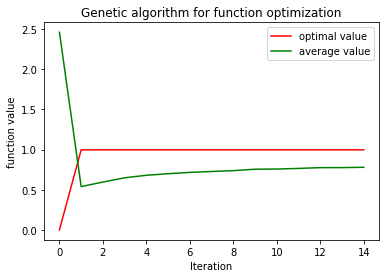

==========SCORE========
0.9979258438535222
=====[adset_id]===== 23843651668300127 ==========[score] 0.5189556044464964
=====[adset_id]===== 23843629487990127 ==========[score] 0.7603569970909695
[optimal_weight]: [0.97589489 0.         0.         0.         0.         0.00325003
 0.0721473 ]
[operation time]:  0:00:19.882963
[campaign_id]: 23843628563810022
[current time]:  2019-08-19 19:29:43.118470
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2019-08-19T15:20:37+0800


[get_adsets_active] adset_active_list: ['23843628563940022', '23843628563930022', '23843628563920022', '23843628563900022', '23843628563870022', '23843628563860022', '23843628563820022']


Generation 0: optimal function value is: -0.977526; average function value is -0.955044
Generation 1: optimal function value is: 44.494938; average function value is 29.265976
Generation 2: optimal function value is: 44.494938; average function value is 33.388702
Generation 3: optimal function value is: 44.494938; average function value is 34.997200
Generation 4: optimal function value is: 44.497752; average function value is 36.765454
Generation 5: optimal function value is: 44.777372; average function value is 38.133784
Generation 6: optimal function value is: 44.777372; average function value is 39.276390
Generation 7: optimal function value is: 44.777372; average function value is 40.265661
Generation 8: optimal function value is: 44.777372; average function value is 40.824742
Generation 9: optimal function value is: 44.777372; average function value is 40.595552
Generation 10: optimal function value is: 44.777372; average function value is 41.073145
Generation 11: optimal function

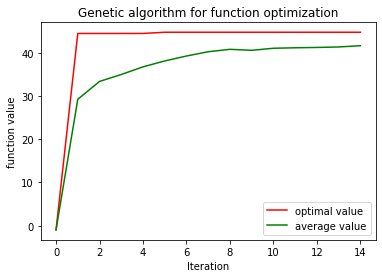

==========SCORE========
44.77737222500802
=====[adset_id]===== 23843628563940022 ==========[score] 23.252510089540966
=====[adset_id]===== 23843628563930022 ==========[score] 12.269256293753559
=====[adset_id]===== 23843628563920022 ==========[score] 1.7690186568319302
=====[adset_id]===== 23843628563900022 ==========[score] 10.00814190683497
=====[adset_id]===== 23843628563870022 ==========[score] 12.411660491914365
=====[adset_id]===== 23843628563860022 ==========[score] 1.7690186568319302
=====[adset_id]===== 23843628563820022 ==========[score] 1.7606831585021685


[optimal_weight]: [0.99992438 0.         0.         0.         0.         0.90301232
 0.86600634]
[operation time]:  0:00:23.178810
[campaign_id]: 23843628364880022
[current time]:  2019-08-19 19:30:06.298524
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2019-08-19T15:20:37+0800


[get_adsets_active] adset_active_list: ['23843628561170022', '23843628364970022', '23843628364960022', '23843628364940022', '23843628364930022', '23843628364920022', '23843628364870022']


Generation 0: optimal function value is: -0.977796; average function value is -0.955796
Generation 1: optimal function value is: 45.036833; average function value is 29.471601
Generation 2: optimal function value is: 45.036833; average function value is 32.933450
Generation 3: optimal function value is: 45.036833; average function value is 34.851206
Generation 4: optimal function value is: 45.036833; average function value is 36.146335
Generation 5: optimal function value is: 45.036833; average function value is 36.865446
Generation 6: optimal function value is: 45.036833; average function value is 37.933273
Generation 7: optimal function value is: 45.036833; average function value is 39.226097
Generation 8: optimal function value is: 45.036833; average function value is 39.719357
Generation 9: optimal function value is: 45.036833; average function value is 39.967944
Generation 10: optimal function value is: 45.036833; average function value is 40.239258
Generation 11: optimal function

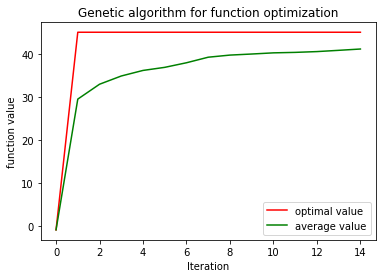

==========SCORE========
45.03683273718456
=====[adset_id]===== 23843628561170022 ==========[score] 1.920644348709084
=====[adset_id]===== 23843628364970022 ==========[score] 1.920644348709084
=====[adset_id]===== 23843628364960022 ==========[score] 1.920644348709084
=====[adset_id]===== 23843628364940022 ==========[score] 1.920644348709084
=====[adset_id]===== 23843628364930022 ==========[score] 1.920644348709084
=====[adset_id]===== 23843628364920022 ==========[score] 1.920644348709084
=====[adset_id]===== 23843628364870022 ==========[score] 1.920644348709084
[optimal_weight]: [0.99509028 0.         0.         0.         0.         0.95128633
 0.96935802]
[operation time]:  0:00:23.219541
[campaign_id]: 23843467729120098
[current time]:  2019-08-19 19:30:29.536040


[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2019-05-02T14:56:07+0800


[get_adsets_active] adset_active_list: ['23843715152780098', '23843714517420098', '23843713666330098', '23843669340520098']


Generation 0: optimal function value is: -0.404590; average function value is 0.232322
Generation 1: optimal function value is: 1.679515; average function value is 0.952939
Generation 2: optimal function value is: 1.679515; average function value is 1.032442
Generation 3: optimal function value is: 1.679515; average function value is 1.073237
Generation 4: optimal function value is: 1.679515; average function value is 1.116014
Generation 5: optimal function value is: 1.679515; average function value is 1.155212
Generation 6: optimal function value is: 1.679515; average function value is 1.171728
Generation 7: optimal function value is: 1.679515; average function value is 1.186310
Generation 8: optimal function value is: 1.679515; average function value is 1.195546
Generation 9: optimal function value is: 1.679515; average function value is 1.215564
Generation 10: optimal function value is: 1.679515; average function value is 1.227843
Generation 11: optimal function value is: 1.679515; 

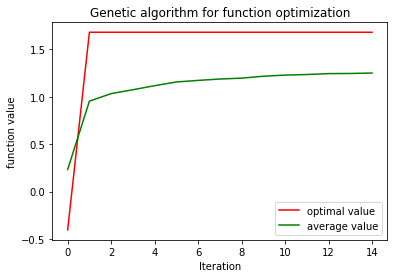

==========SCORE========
1.6795146042674116
=====[adset_id]===== 23843715152780098 ==========[score] 1.8834772353838711
=====[adset_id]===== 23843714517420098 ==========[score] 1.8216585001552872
=====[adset_id]===== 23843713666330098 ==========[score] 2.1236459094700573
=====[adset_id]===== 23843669340520098 ==========[score] -3.38940808338174
[optimal_weight]: [0.39120647 0.60089039 0.98250283 0.2066891  0.95638597 0.95497493
 0.08984211]
[operation time]:  0:00:21.942914
[campaign_id]: 23843384204790368
[current time]:  2019-08-19 19:30:51.480423


[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2019-04-08T08:30:28+0800


[get_adsets_active] adset_active_list: ['23843694481330368', '23843661314820368', '23843482074960368', '23843451198530368', '23843384205000368']


Generation 0: optimal function value is: 0.332410; average function value is 2.067450
Generation 1: optimal function value is: 0.750520; average function value is 0.424893
Generation 2: optimal function value is: 0.750520; average function value is 0.455997
Generation 3: optimal function value is: 0.750520; average function value is 0.474365
Generation 4: optimal function value is: 0.750520; average function value is 0.485058
Generation 5: optimal function value is: 0.750520; average function value is 0.496871
Generation 6: optimal function value is: 0.750520; average function value is 0.498290
Generation 7: optimal function value is: 0.750520; average function value is 0.498387
Generation 8: optimal function value is: 0.750520; average function value is 0.503976
Generation 9: optimal function value is: 0.750520; average function value is 0.505447
Generation 10: optimal function value is: 0.750520; average function value is 0.506316
Generation 11: optimal function value is: 0.750520; a

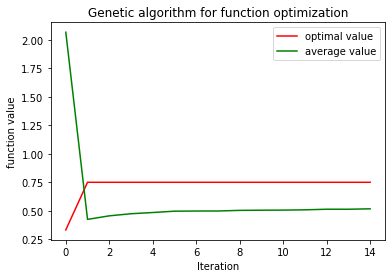

==========SCORE========
0.7505195172604624


=====[adset_id]===== 23843694481330368 ==========[score] 0.9265660719638114
=====[adset_id]===== 23843661314820368 ==========[score] 0.5508001737806332
=====[adset_id]===== 23843482074960368 ==========[score] -2.1423451438585417
=====[adset_id]===== 23843451198530368 ==========[score] -0.8889361383435685
=====[adset_id]===== 23843384205000368 ==========[score] -1.1381663334820007
[optimal_weight]: [0.31833275 0.84074609 0.02238625 0.52556667 0.99513462 0.31244071
 0.99981247]
[operation time]:  0:00:22.253632
[campaign_id]: 23843484377040702
[current time]:  2019-08-19 19:31:13.735811
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name

[get_adsets_active] adset_active_list: ['23843705400280702', '23843686443530702', '23843655600250702', '23843603174320702', '23843603170470702', '23843484398840702']


Generation 0: optimal function value is: -0.689549; average function value is -0.427431
Generation 1: optimal function value is: 3.221118; average function value is 1.995233
Generation 2: optimal function value is: 3.221118; average function value is 2.182009
Generation 3: optimal function value is: 3.221118; average function value is 2.293858
Generation 4: optimal function value is: 3.221118; average function value is 2.347113
Generation 5: optimal function value is: 3.221118; average function value is 2.365014
Generation 6: optimal function value is: 3.221118; average function value is 2.413474
Generation 7: optimal function value is: 3.221118; average function value is 2.428169
Generation 8: optimal function value is: 3.221118; average function value is 2.451167
Generation 9: optimal function value is: 3.221118; average function value is 2.468884
Generation 10: optimal function value is: 3.221118; average function value is 2.503033
Generation 11: optimal function value is: 3.221118;

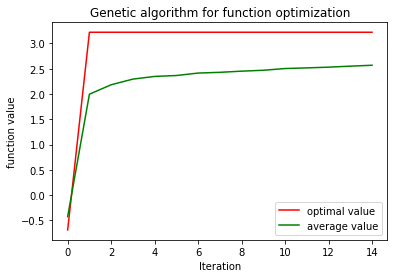

==========SCORE========
3.2211176487789652
=====[adset_id]===== 23843705400280702 ==========[score] 1.6986486250792394
=====[adset_id]===== 23843686443530702 ==========[score] 2.190575975415854
=====[adset_id]===== 23843655600250702 ==========[score] 1.69962975457219
=====[adset_id]===== 23843603174320702 ==========[score] 1.3341885318707833
=====[adset_id]===== 23843603170470702 ==========[score] -3.1489100031845245
=====[adset_id]===== 23843484398840702 ==========[score] -1.9553823288669105
[optimal_weight]: [0.01306642 0.66566831 0.9884333  0.47293675 0.98374006 0.98112949
 0.71850026]
[operation time]:  0:00:23.374721
[campaign_id]: 23843240188270516
[current time]:  2019-08-19 19:31:37.112263
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8M

[get_adsets_active] adset_active_list: ['23843604461570516', '23843592635130516', '23843559316390516', '23843535499680516', '23843428896680516', '23843428894470516']


Generation 0: optimal function value is: 0.958743; average function value is 3.286563
Generation 1: optimal function value is: 0.510532; average function value is 0.334723
Generation 2: optimal function value is: 0.511083; average function value is 0.361579
Generation 3: optimal function value is: 0.511083; average function value is 0.382078
Generation 4: optimal function value is: 0.513869; average function value is 0.387779
Generation 5: optimal function value is: 0.513869; average function value is 0.392449
Generation 6: optimal function value is: 0.513869; average function value is 0.397081
Generation 7: optimal function value is: 0.513869; average function value is 0.399839
Generation 8: optimal function value is: 0.513869; average function value is 0.401491
Generation 9: optimal function value is: 0.513869; average function value is 0.401393
Generation 10: optimal function value is: 0.513869; average function value is 0.405045
Generation 11: optimal function value is: 0.513869; a

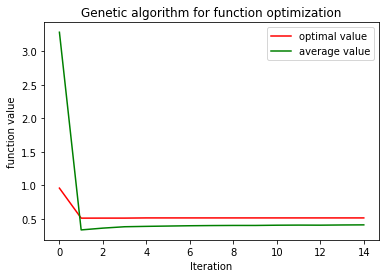

==========SCORE========
0.5138689739688992
=====[adset_id]===== 23843604461570516 ==========[score] 0.2924380639890884
=====[adset_id]===== 23843592635130516 ==========[score] 0.03708913843699303
=====[adset_id]===== 23843559316390516 ==========[score] -0.7867031270082954
=====[adset_id]===== 23843535499680516 ==========[score] 0.5567794332684488
=====[adset_id]===== 23843428896680516 ==========[score] -2.7352863474044513
=====[adset_id]===== 23843428894470516 ==========[score] -3.571789351940114
[optimal_weight]: [0.75781217 0.35019829 0.36478309 0.65052777 0.99009897 0.51739567
 0.04792079]
[operation time]:  0:00:23.307680
[campaign_id]: 23843098840440451
[current time]:  2019-08-19 19:32:00.421541
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHt

[get_adsets_active] adset_active_list: ['23843646345400451', '23843621672470451', '23843621652590451', '23843621647530451', '23843345040900451', '23843098840580451']


Generation 0: optimal function value is: -0.674221; average function value is -0.435727
Generation 1: optimal function value is: 3.136261; average function value is 1.920460
Generation 2: optimal function value is: 3.136261; average function value is 2.043356
Generation 3: optimal function value is: 3.136261; average function value is 2.147539
Generation 4: optimal function value is: 3.136261; average function value is 2.182515
Generation 5: optimal function value is: 3.136261; average function value is 2.254796
Generation 6: optimal function value is: 3.136261; average function value is 2.279985
Generation 7: optimal function value is: 3.136261; average function value is 2.320267
Generation 8: optimal function value is: 3.136261; average function value is 2.346322
Generation 9: optimal function value is: 3.136261; average function value is 2.367616
Generation 10: optimal function value is: 3.136261; average function value is 2.401278
Generation 11: optimal function value is: 3.136261;

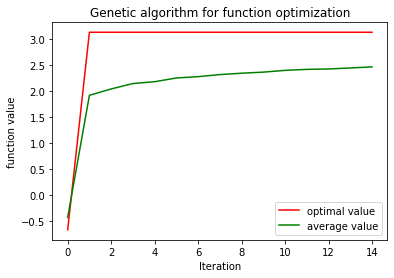

==========SCORE========
3.1362606715653945
=====[adset_id]===== 23843646345400451 ==========[score] 3.8753884675209083
=====[adset_id]===== 23843621672470451 ==========[score] 2.837686870316204
=====[adset_id]===== 23843621652590451 ==========[score] 1.9770642177081084
=====[adset_id]===== 23843621647530451 ==========[score] 3.113211786101497
=====[adset_id]===== 23843345040900451 ==========[score] 4.449056260907893
=====[adset_id]===== 23843098840580451 ==========[score] 0.5960398838823541
[optimal_weight]: [0.78238677 0.97504085 0.9832703  0.41108914 0.49415413 0.48538984
 0.85501845]
[operation time]:  0:00:23.604805
[campaign_id]: 23843473390820344
[current time]:  2019-08-19 19:32:24.028216


[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'credential_refresh_token': None, 'name': 'AntMan Facebook Credential'}
self.campaign_features[Field.start_time] 2019-07-23T18:36:37+0800


[get_adsets_active] adset_active_list: ['23843511657650344', '23843511656660344', '23843477945310344', '23843476995720344', '23843473402760344']


Generation 0: optimal function value is: -0.582524; average function value is -0.213237
Generation 1: optimal function value is: 2.395349; average function value is 1.366506
Generation 2: optimal function value is: 2.395349; average function value is 1.436615
Generation 3: optimal function value is: 2.395349; average function value is 1.481290
Generation 4: optimal function value is: 2.395349; average function value is 1.509568
Generation 5: optimal function value is: 2.395349; average function value is 1.532929
Generation 6: optimal function value is: 2.395349; average function value is 1.533267
Generation 7: optimal function value is: 2.395349; average function value is 1.549063
Generation 8: optimal function value is: 2.395349; average function value is 1.558745
Generation 9: optimal function value is: 2.395349; average function value is 1.571495
Generation 10: optimal function value is: 2.395349; average function value is 1.586581
Generation 11: optimal function value is: 2.395349;

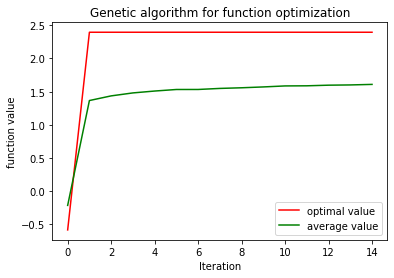

==========SCORE========
2.395349382975226
=====[adset_id]===== 23843511657650344 ==========[score] 1.9728773232371335
=====[adset_id]===== 23843511656660344 ==========[score] 1.74859405800537
=====[adset_id]===== 23843477945310344 ==========[score] 22.76556977027287
=====[adset_id]===== 23843476995720344 ==========[score] 4.805973024318033
=====[adset_id]===== 23843473402760344 ==========[score] 5.772369593463438
[optimal_weight]: [0.96448714 0.23614348 0.80952258 0.3955688  0.80632792 0.97821827
 0.99465905]
[operation time]:  0:00:21.910218
[campaign_id]: 23843468131980091
[current time]:  2019-08-19 19:32:45.940083
[get_media_token_by_queryid] token_dic {'credential_id': '958842090856883', 'credential_secret': 'a952f55afca38572cea2994d440d674b', 'credential_token': 'EAANoD9I4obMBAH8xjIhGjHc9DmLDeBDTauvkO3tk5x05v1E3G72Qp33aP4gLkE3IZBUDyCMkqCLLPS6DKk8mUJLcsncIrjveFLZCKUseqU7Qy2iIeEq0Dx8DgZAuRwhUNFkKHtmU8McAAWbWMNi2hiWZAbZAXDAyTCd1xXHUJmQZDZD', 'credential_developer_token': None, 'cred

[get_adsets_active] adset_active_list: ['23843521405370091', '23843521395560091', '23843508308220091', '23843506833550091', '23843468170280091']


Generation 0: optimal function value is: -0.711191; average function value is -0.464895
Generation 1: optimal function value is: 3.462494; average function value is 2.163910
Generation 2: optimal function value is: 3.462494; average function value is 2.378015
Generation 3: optimal function value is: 3.509224; average function value is 2.522478
Generation 4: optimal function value is: 3.514379; average function value is 2.589955


In [ ]:
if __name__ == "__main__":
    main()
    import gc
    gc.collect()
#     main(campaign_id=23843467729120098)

In [ ]:
# !jupyter nbconvert --to script genetic_algorithm.ipynb